In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from IPython import HTML

ImportError: cannot import name 'HTML' from 'IPython' (/Users/pranamshetty/Developer/Projects/TomatoSaviorAI/venv/lib/python3.11/site-packages/IPython/__init__.py)

In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = (256, 256)

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    batch_size= BATCH_SIZE,
    image_size= IMAGE_SIZE,
    shuffle=True,
    seed=32,

)

Found 16011 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [6]:
len(dataset)

1001

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 256, 256, 3)
[9 4 6 7 2 7 3 0 7 0 5 7 9 1 8 5]


2024-08-17 00:28:58.291506: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-08-17 00:28:58.478741: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


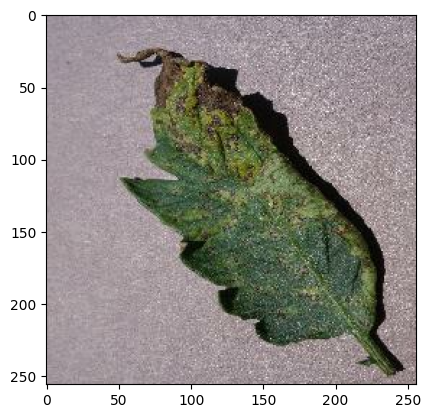

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

In [10]:
def get_partitioned_datasets(dataset, train_split=0.8, val_split = 0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=10)

    dataset_len = len(dataset)
    train_len = int( train_split * dataset_len)
    train_dataset = dataset.take(train_len)
    dataset = dataset.skip(train_len)

    val_len = int(val_split * dataset_len)
    val_dataset = dataset.take(val_len)
    dataset = dataset.skip(val_len)

    test_len = dataset_len - train_len - val_len
    test_dataset = dataset.take(test_len)

    return train_dataset, val_dataset, test_dataset

In [11]:
train_dataset, val_dataset, test_dataset = get_partitioned_datasets(dataset)

In [12]:
len(train_dataset)

800

In [13]:
len(val_dataset)

100

In [14]:
len(test_dataset)

101

In [15]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
class ResizeAndRescale(layers.Layer):
    def __init__(self, size, **kwargs):
        super(ResizeAndRescale, self).__init__(**kwargs)
        self.size = size
        self.resize = layers.Resizing(size, size)
        self.rescale = layers.Rescaling( 1.0/255)

    def build(self, input_shape):
        super(ResizeAndRescale, self).build(input_shape)
        
    def call(self, inputs):
        x = self.resize(inputs)
        return self.rescale(x)
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.size, self.size, input_shape[-1])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

In [18]:
CHANNELS = 3
ONE_IMAGE_SIZE=256
input_shape = (ONE_IMAGE_SIZE, ONE_IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential ([
    layers.Input(shape=input_shape),
    ResizeAndRescale(ONE_IMAGE_SIZE, name ='resize_and_rescale'),
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resize_and_rescale              │ (None, 256, 256, 3)    │             0 │
│ (ResizeAndRescale)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [24]:
model.fit(
    train_dataset, 
    batch_size = BATCH_SIZE,
    validation_data = val_dataset,
    verbose =1,
    epochs = 8
)

Epoch 1/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 226s 276ms/step - accuracy: 0.3682 - loss: 1.7585 - val_accuracy: 0.6875 - val_loss: 0.8560
Epoch 2/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 230s 287ms/step - accuracy: 0.7175 - loss: 0.7786 - val_accuracy: 0.8081 - val_loss: 0.5375
Epoch 3/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 199s 248ms/step - accuracy: 0.8427 - loss: 0.4551 - val_accuracy: 0.8788 - val_loss: 0.3501
Epoch 4/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 199s 249ms/step - accuracy: 0.8753 - loss: 0.3518 - val_accuracy: 0.9062 - val_loss: 0.2754
Epoch 5/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 197s 246ms/step - accuracy: 0.9106 - loss: 0.2650 - val_accuracy: 0.9131 - val_loss: 0.2634
Epoch 6/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 194s 243ms/step - accuracy: 0.9274 - loss: 0.2201 - val_accuracy: 0.9119 - val_loss: 0.2637
Epoch 7/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 191s 239ms/step - accuracy: 0.9341 - loss: 0.1921 - val_accuracy: 0.8963 - val_loss: 0.3038
Epoch 8/8
800/800 ━━━━━━━━━━━━━━━━━━━━ 192s 240ms/step - accuracy: 0.9390 - loss: 0

In [25]:
model.evaluate(test_dataset)

101/101 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step - accuracy: 0.9611 - loss: 0.1149


[0.13190175592899323, 0.9566831588745117]

The First Image: 
The First Images actual Label:  Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
The Predicted Label:  Tomato__Tomato_YellowLeaf__Curl_Virus


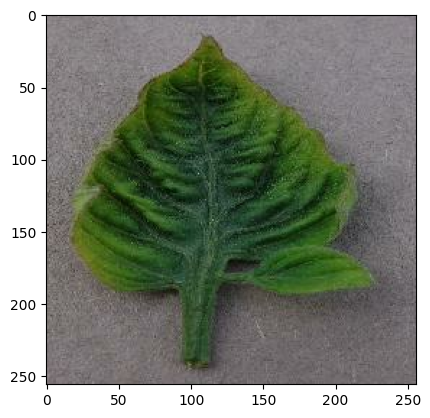

In [29]:
for image_batch, label_batch in test_dataset.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]

    print( "The First Image: ")
    plt.imshow(first_image)
    print("The First Images actual Label: ",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("The Predicted Label: ", class_names[np.argmax(batch_prediction[0])])
    